<a href="https://colab.research.google.com/github/alexandergrishin/suitar/blob/master/posenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing PoseNet

In [1]:
 # Clone the repo and install 3rd-party libraries. 
!git clone https://www.github.com/ildoonet/tf-openpose 
%cd tf-openpose
!pip3 install -r requirements.txt

# Build c++ library for post processing. See : https://github.com/ildoonet/tf-pose-estimation/tree/master/tf_pose/pafprocess
%cd tf_pose/pafprocess
!sudo apt install swig
!swig -python -c++ pafprocess.i && python3 setup.py build_ext --inplace
%cd ../..

Cloning into 'tf-openpose'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 1274 (delta 0), reused 7 (delta 0), pack-reused 1254
Receiving objects: 100% (1274/1274), 84.42 MiB | 12.47 MiB/s, done.
Resolving deltas: 100% (660/660), done.
/content/tf-openpose
  Cloning https://github.com/ppwwyyxx/tensorpack.git to /tmp/pip-req-build-l3pedajg
  Stored in directory: /root/.cache/pip/wheels/2a/1a/4d/6b30377c3051e76559d1185c1dbbfff15aed31f87acdd14c22
  Stored in directory: /tmp/pip-ephem-wheel-cache-7t35o16t/wheels/a8/b5/a9/025b3a1294b9ffff93309e6956c65aa80e0fa40821d29eff1e
Successfully built fire tensorpack
thinc 6.12.1 has requirement msgpack-numpy<0.4.4, but you'll have msgpack-numpy 0.4.4.2 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 

/content/tf-openpose/tf_pose/pafprocess
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 10 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 2s (451 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to i

# Test the Posenet api

## Upload image from google drive

In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
from google.colab import files
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 7.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
#https://drive.google.com/file/d/1bd0POOdO5R5FimgNL579yTxxif7m79_M/view?usp=sharing
#https://drive.google.com/file/d/10tekxZToYnRxbGVhmiqEcH64WKIyXJdL/view?usp=sharing
#https://drive.google.com/file/d/1m2rtdRzcB9FVMwzFiYg2T7_w9jFLU0dx/view?usp=sharing
#https://drive.google.com/file/d/198ZRSerozSm63m6tL7wK1kT8dAbjYKGw/view?usp=sharing
#https://drive.google.com/file/d/1hzOvII2nQh-VZnnnwHCx2MJtSdfa4T9q/view?usp=sharing
download = drive.CreateFile({'id': '116dCMfKIdh5kv5xTNBhvRoS07uoKMV2B'})
download.GetContentFile('ex1.jpg')
download = drive.CreateFile({'id': '1bd0POOdO5R5FimgNL579yTxxif7m79_M'})
download.GetContentFile('ex2.jpg')
download = drive.CreateFile({'id': '10tekxZToYnRxbGVhmiqEcH64WKIyXJdL'})
download.GetContentFile('ex3.jpg')
download = drive.CreateFile({'id': '1m2rtdRzcB9FVMwzFiYg2T7_w9jFLU0dx'})
download.GetContentFile('ex4.jpg')
download = drive.CreateFile({'id': '198ZRSerozSm63m6tL7wK1kT8dAbjYKGw'})
download.GetContentFile('ex5.jpg')
download = drive.CreateFile({'id': '1hzOvII2nQh-VZnnnwHCx2MJtSdfa4T9q'})
download.GetContentFile('ex6.jpg')

# Getting pose

In [4]:
import argparse
import logging
import sys
import time

from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
logger = logging.getLogger('TfPoseEstimator')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
w, h = model_wh('432x368')
if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path('mobilenet_thin'), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path('mobilenet_thin'), target_size=(w, h))
def pose_estimate(image_path):
    
        
    # estimate human poses from a single image !
    image = common.read_imgfile(image_path, None, None)
    if image is None:
        logger.error('Image can not be read, path=%s' % image)
        sys.exit(-1)
    t = time.time()
    humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
    elapsed = time.time() - t

    logger.info('inference image: %s in %.4f seconds.' % (image_path, elapsed))
    image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
    return image


[2019-02-28 13:26:56,668] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)
[2019-02-28 13:26:56,668] [TfPoseEstimator] [INFO] loading graph from /content/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)


Instructions for updating:
Colocations handled automatically by placer.


In [5]:
#choose ex1.jpg, ex2.jpg, ex3.jpg or ex4.jpg
image_path = './ex5.jpg'
new_img = pose_estimate(image_path)
new_img_path = './'+'new_'+ image_path[2:]
print(new_img_path)
cv2.imwrite(new_img_path, new_img)


[2019-02-28 13:27:01,656] [TfPoseEstimator] [DEBUG] inference+ original shape=725x1000
[2019-02-28 13:27:01,656] [TfPoseEstimator] [DEBUG] inference+ original shape=725x1000
[2019-02-28 13:27:01,719] [TfPoseEstimator] [DEBUG] inference- heatMat=216x184 pafMat=216x184
[2019-02-28 13:27:01,719] [TfPoseEstimator] [DEBUG] inference- heatMat=216x184 pafMat=216x184
[2019-02-28 13:27:01,727] [TfPoseEstimator] [DEBUG] estimate time=0.00224
[2019-02-28 13:27:01,727] [TfPoseEstimator] [DEBUG] estimate time=0.00224
[2019-02-28 13:27:01,731] [TfPoseEstimator] [INFO] inference image: ./ex5.jpg in 0.0758 seconds.
[2019-02-28 13:27:01,731] [TfPoseEstimator] [INFO] inference image: ./ex5.jpg in 0.0758 seconds.


./new_ex5.jpg


True

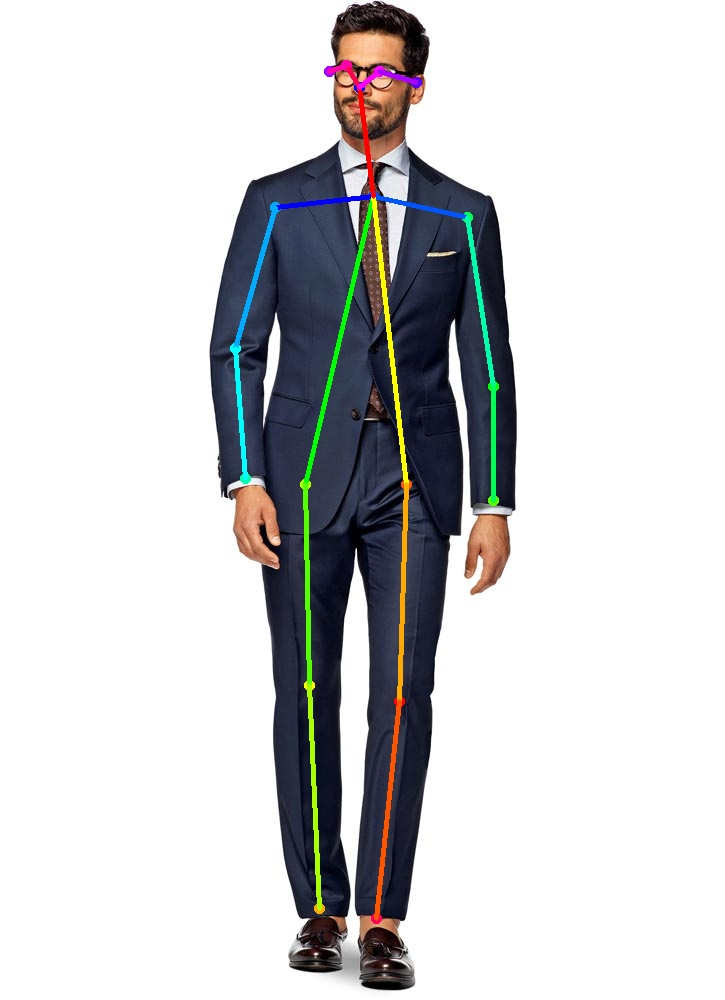

In [6]:
from IPython.display import Image, display
# display(Image(image_path))
display(Image(new_img_path))

###Posenet give response in this format: 


```
BodyPart:0-(0.27, 0.18) score=0.84 
BodyPart:1-(0.27, 0.28) score=0.70 
BodyPart:2-(0.19, 0.30) score=0.71 
BodyPart:3-(0.16, 0.47) score=0.72 
BodyPart:4-(0.20, 0.53) score=0.83 
BodyPart:5-(0.36, 0.27) score=0.70 
BodyPart:6-(0.44, 0.42) score=0.81 
BodyPart:7-(0.33, 0.54) score=0.50 
BodyPart:8-(0.23, 0.53) score=0.39 
BodyPart:9-(0.10, 0.61) score=0.80 
BodyPart:10-(0.18, 0.88) score=0.67
BodyPart:11-(0.36, 0.55) score=0.44 
BodyPart:12-(0.25, 0.62) score=0.70 
BodyPart:13-(0.26, 0.90) score=0.62
BodyPart:14-(0.25, 0.16) score=0.80
BodyPart:15-(0.29, 0.16) score=0.90
BodyPart:16-(0.22, 0.18) score=0.80 
BodyPart:17-(0.31, 0.18) score=0.61
```




In [0]:
# to download the processed image
files.download(new_img_path)